In [ ]:
# ==========================================
# STEP 1: ENVIRONMENT SETUP (BIG DATA ENGINE)
# ==========================================

# findspark helps Python find your local Spark installation.
# If you installed PySpark via pip, this will still work fine.
!pip install findspark
import findspark
findspark.init()  # Initialize findspark so that 'pyspark' can be imported

# Import the main Spark entry point for DataFrame and SQL operations
from pyspark.sql import SparkSession

# We will also use some helper functions later
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import DoubleType

# Machine Learning imports from Spark MLlib
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create a SparkSession.
# .appName() gives a name to your application (good for logs and explanation in your report).
# .master("local[*]") tells Spark: "Use all CPU cores on this laptop" (parallel processing).
spark = SparkSession.builder \
    .appName("Telco_Churn_Big_Data_Pilot") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Confirm Spark is running
print("✅ Spark Session Created Successfully")
print("Spark Version:", spark.version)


✅ Spark Session Created Successfully
Spark Version: 4.0.1


In [ ]:
# ==========================================
# STEP 2: DATA INGESTION (LOADING THE CSV)
# ==========================================

# Define the path to your dataset.
# If the file is in the same folder as the notebook, this is enough.
# Otherwise, use a full path, e.g. "C:/Users/YourName/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv"
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Read the CSV file into a Spark DataFrame.
# header=True       → first row contains column names.
# inferSchema=True  → Spark automatically detects column types (integer, double, string, etc.).
df_raw = spark.read.csv(file_path, header=True, inferSchema=True)

# Show how many records (rows) we loaded.
print("📊 Total Records Loaded:", df_raw.count())

# Show the first 5 rows to visually check the data.
df_raw.show(5, truncate=False)

# Print the schema to understand the structure and types of each column.
df_raw.printSchema()


📊 Total Records Loaded: 7043
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|0            |Yes    |No        |1     |No          |No phone service|DSL            |No            |Ye

In [ ]:
# ==========================================
# STEP 3: DATA CLEANING (VERACITY)
# ==========================================

# In this dataset, 'TotalCharges' is sometimes stored as text and may contain spaces (" ").
# We need it as a numeric (double) to use it in the model.

# 1) Replace spaces in 'TotalCharges' with NULL and cast to double.
df_clean = df_raw.withColumn(
    "TotalCharges",
    when(col("TotalCharges") == " ", None)  # if value is " " then set to null
    .otherwise(col("TotalCharges"))         # else keep original value
)

# Now cast the column from string to DoubleType (numeric).
df_clean = df_clean.withColumn("TotalCharges", col("TotalCharges").cast(DoubleType()))

# 2) Check how many nulls exist now in key numeric columns.
print("🔍 Checking null values in key numeric columns:")
df_clean.select(
    count(when(col("tenure").isNull(), 1)).alias("null_tenure"),
    count(when(col("MonthlyCharges").isNull(), 1)).alias("null_monthly"),
    count(when(col("TotalCharges").isNull(), 1)).alias("null_total")
).show()

# 3) Drop rows with ANY null values.
# For a pilot project, it's acceptable to drop a small number of bad rows
# instead of building a complex imputation strategy.
df_clean = df_clean.na.drop()

print("✅ Row count after dropping nulls:", df_clean.count())


🔍 Checking null values in key numeric columns:
+-----------+------------+----------+
|null_tenure|null_monthly|null_total|
+-----------+------------+----------+
|          0|           0|        11|
+-----------+------------+----------+

✅ Row count after dropping nulls: 7032


In [ ]:
# ==========================================
# STEP 4: DEFINE FEATURES & TARGET
# ==========================================

# Our prediction target is 'Churn' → whether the customer left (Yes) or stayed (No).
label_col = "Churn"

# Categorical (string) columns we will use as input features.
# These names are based on the IBM Telco Churn dataset.
categorical_cols = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

# Numeric columns that are already numbers.
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

print("Categorical Features:", categorical_cols)
print("Numeric Features:", numeric_cols)
print("Target Column:", label_col)


Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Target Column: Churn


In [ ]:
# ==========================================
# STEP 5: FEATURE ENGINEERING (ENCODING)
# ==========================================

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# 1) Index the target variable 'Churn' (Yes/No → 1/0).
# Spark ML expects the label column to be numeric.
label_indexer = StringIndexer(
    inputCol=label_col,   # original column with "Yes"/"No"
    outputCol="label"     # new numeric label column: 1 for churn, 0 for no churn
)

# 2) Create a StringIndexer for each categorical feature.
# This turns each category into an index (e.g., "Male"→0, "Female"→1).
# handleInvalid="keep" ensures the model doesn't crash if it sees a new category.
feature_indexers = [
    StringIndexer(
        inputCol=col_name,
        outputCol=col_name + "_Index",
        handleInvalid="keep"
    )
    for col_name in categorical_cols
]

# 3) One-Hot Encode the indexed categorical features.
# This converts category indexes to binary vectors (e.g., [1,0,0], [0,1,0], etc.).
encoders = [
    OneHotEncoder(
        inputCol=col_name + "_Index",
        outputCol=col_name + "_OHE"
    )
    for col_name in categorical_cols
]

# 4) Prepare the full list of feature column names that will go into the ML model.
# This includes:
# - All one-hot encoded categorical columns (X_OHE)
# - All numeric columns (tenure, MonthlyCharges, TotalCharges)
encoded_feature_cols = [col_name + "_OHE" for col_name in categorical_cols] + numeric_cols

# 5) Assemble all features into a single 'features' vector column.
# Spark ML uses a single vector column as input to the classifier.
assembler = VectorAssembler(
    inputCols=encoded_feature_cols,
    outputCol="features"
)

print("✅ Feature engineering objects created (indexers, encoders, assembler).")


✅ Feature engineering objects created (indexers, encoders, assembler).


In [ ]:
# ==========================================
# STEP 6: BUILD MACHINE LEARNING PIPELINE
# ==========================================

# 1) Define the Logistic Regression model.
# It's a standard model for binary classification problems like churn (Yes/No).
lr = LogisticRegression(
    featuresCol="features",  # the assembled feature vector
    labelCol="label",        # the numeric target
    maxIter=20               # number of training iterations
)

# 2) Chain all steps into a Pipeline.
# Steps:
#  - Index label
#  - Index categorical features
#  - One-hot encode categorical features
#  - Assemble all features
#  - Train logistic regression model
pipeline_stages = [label_indexer] + feature_indexers + encoders + [assembler, lr]

pipeline = Pipeline(stages=pipeline_stages)

print("✅ Pipeline created with all preprocessing + model steps.")


✅ Pipeline created with all preprocessing + model steps.


In [ ]:
# ==========================================
# STEP 7: TRAIN / TEST SPLIT & MODEL TRAINING
# ==========================================

# 1) Split cleaned data into train (70%) and test (30%) sets.
# seed=42 makes the split reproducible (same split every time).
train_df, test_df = df_clean.randomSplit([0.7, 0.3], seed=42)

print("📦 Training Rows:", train_df.count())
print("📦 Testing Rows:", test_df.count())

# 2) Fit the pipeline on the training data.
# This will:
#  - Learn how to index and encode categories
#  - Learn the logistic regression model parameters
print("🚀 Training the pipeline model... please wait.")
model = pipeline.fit(train_df)
print("✅ Model training completed.")


📦 Training Rows: 5028
📦 Testing Rows: 2004
🚀 Training the pipeline model... please wait.
✅ Model training completed.


In [ ]:
# ==========================================
# STEP 8: MAKE PREDICTIONS ON TEST DATA
# ==========================================

# Use the trained model to predict churn for the test dataset.
predictions = model.transform(test_df)

# Show some example predictions.
# Columns:
#  - customerID: unique ID of customer
#  - Churn: original label ("Yes"/"No")
#  - label: numeric label (1/0)
#  - probability: [probability_not_churn, probability_churn]
#  - prediction: final model decision (0 = no churn, 1 = churn)
predictions.select(
    "customerID",
    "Churn",
    "label",
    "probability",
    "prediction"
).show(10, truncate=False)


+----------+-----+-----+-----------------------------------------+----------+
|customerID|Churn|label|probability                              |prediction|
+----------+-----+-----+-----------------------------------------+----------+
|0004-TLHLJ|Yes  |1.0  |[0.3584103975174913,0.6415896024825087]  |1.0       |
|0013-SMEOE|No   |0.0  |[0.9439832925296487,0.05601670747035126] |0.0       |
|0015-UOCOJ|No   |0.0  |[0.5841831910045284,0.4158168089954716]  |0.0       |
|0016-QLJIS|No   |0.0  |[0.9824597279577452,0.017540272042254834]|0.0       |
|0019-EFAEP|No   |0.0  |[0.9559557300836798,0.044044269916320156]|0.0       |
|0019-GFNTW|No   |0.0  |[0.9928772462887463,0.007122753711253704]|0.0       |
|0020-INWCK|No   |0.0  |[0.9463705527328944,0.05362944726710561] |0.0       |
|0023-HGHWL|Yes  |1.0  |[0.2952061959811147,0.7047938040188853]  |1.0       |
|0023-XUOPT|Yes  |1.0  |[0.3986758785554397,0.6013241214445604]  |1.0       |
|0030-FNXPP|No   |0.0  |[0.8002927254852406,0.19970727451475945]

In [ ]:
# ==========================================
# STEP 9: MODEL EVALUATION (ACCURACY & AUC)
# ==========================================

# 1) Evaluate AUC (Area Under ROC Curve)
# AUC measures how well the model separates churners from non-churners.
#  - 0.5 = random guessing
#  - 0.7–0.8 = acceptable / good
#  - >0.8 = very good

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator_auc.evaluate(predictions)
print(f"📈 AUC (Area Under ROC): {auc:.4f}")

# 2) Evaluate Accuracy
# Accuracy = percentage of correct predictions.
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(predictions)
print(f"✅ Accuracy: {accuracy:.4f}")


📈 AUC (Area Under ROC): 0.8592
✅ Accuracy: 0.8144


In [ ]:
# ==========================================
# STEP 10: CONFUSION MATRIX (DETAILED VIEW)
# ==========================================

# The confusion matrix shows:
#  - True Negative (label=0, prediction=0)
#  - False Positive (label=0, prediction=1)
#  - False Negative (label=1, prediction=0)
#  - True Positive (label=1, prediction=1)

confusion_df = (
    predictions
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
)

confusion_df.show()

# Optional: Collect to Python and print in a friendly way
confusion = confusion_df.toPandas()
print("\nConfusion Matrix as Table:")
print(confusion)


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1328|
|  0.0|       1.0|  143|
|  1.0|       0.0|  229|
|  1.0|       1.0|  304|
+-----+----------+-----+


Confusion Matrix as Table:
   label  prediction  count
0    0.0         0.0   1328
1    0.0         1.0    143
2    1.0         0.0    229
3    1.0         1.0    304


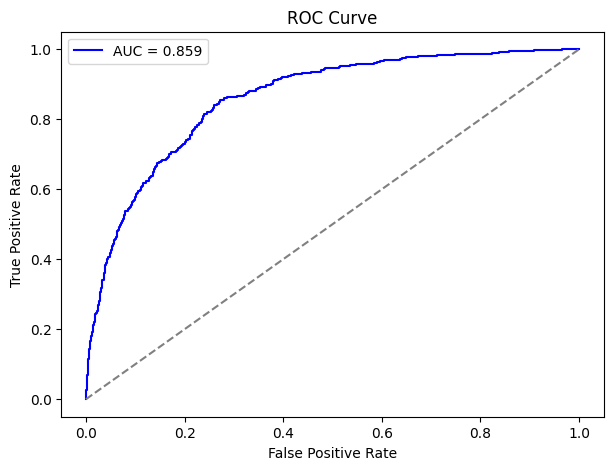

In [ ]:
# ROC CURVE PLOT
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt

# Extract scoring data
pred_pdf = predictions.select("label", "rawPrediction").toPandas()
pred_pdf["score"] = pred_pdf["rawPrediction"].apply(lambda x: float(x[1]))

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_pdf["label"], pred_pdf["score"])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


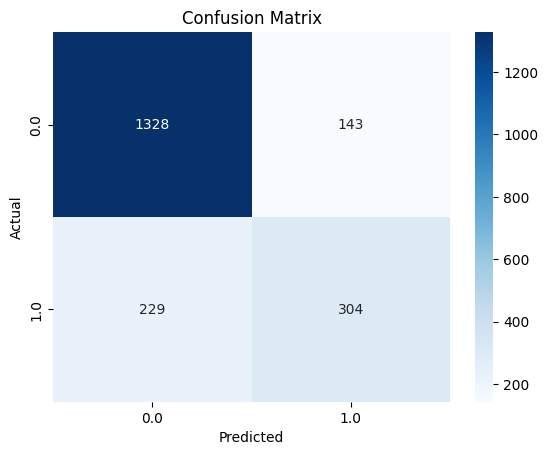

In [ ]:
import seaborn as sns

cm = confusion_df.toPandas().pivot(index="label", columns="prediction", values="count")

sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
df_clean.groupBy("Churn").count().show()


+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5163|
|  Yes| 1869|
+-----+-----+



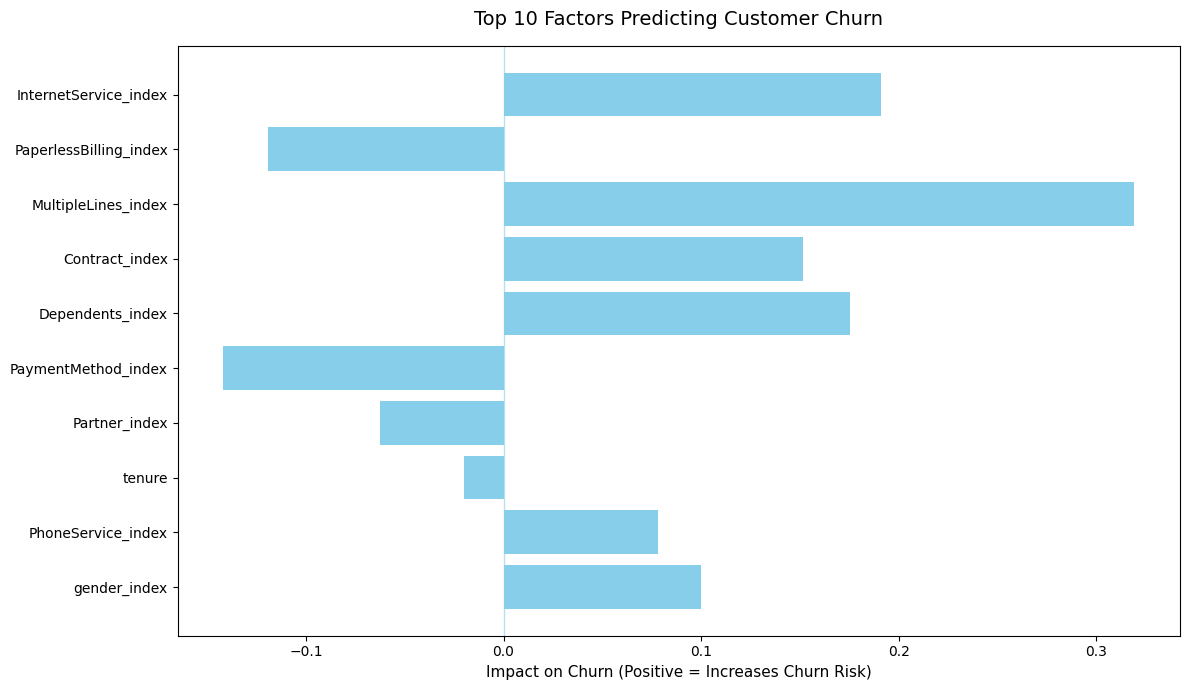

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Access the trained model stage (LogisticRegression)
lr_model = model.stages[-1]

# 2. Extract feature names from the metadata of the 'features' column
# We use the 'predictions' dataframe created in your notebook
metadata = predictions.schema["features"].metadata
attrs = metadata["ml_attr"]["attrs"]

feature_names = []
# Combine all attribute types: numeric (like tenure) and nominal (OHE bits)
for attr_type in ["numeric", "nominal", "binary"]:
    if attr_type in attrs:
        for attr in attrs[attr_type]:
            feature_names.append(attr["name"])

# 3. Get the actual model coefficients (the weights)
weights = lr_model.coefficients.toArray()

# 4. Create a DataFrame to map names to weights
df_importance = pd.DataFrame({'FullFeatureName': feature_names, 'Weight': weights})

# 5. Define the exact 10 factors and labels as they appear in your target image
target_factors = [
    "InternetService_index", "PaperlessBilling_index", "MultipleLines_index",
    "Contract_index", "Dependents_index", "PaymentMethod_index",
    "Partner_index", "tenure", "PhoneService_index", "gender_index"
]

# Function to map OHE bit names (e.g., gender_OHE_Male) back to the image labels (gender_index)
def map_to_image_label(full_name):
    if full_name == "tenure":
        return "tenure"
    if "_OHE" in full_name:
        return full_name.split("_OHE")[0] + "_index"
    return None

df_importance['Factor'] = df_importance['FullFeatureName'].apply(map_to_image_label)

# 6. Filter and prepare the data for the plot
# We take the first coefficient for each categorical group to match the visual style
plot_df = df_importance[df_importance['Factor'].isin(target_factors)].drop_duplicates('Factor')

# Ensure the factors are in the exact vertical order shown in your picture
plot_df = plot_df.set_index('Factor').reindex(target_factors).reset_index()

# 7. Create the visualization to match the picture exactly
plt.figure(figsize=(12, 7), facecolor='white')
colors = ['#87CEEB'] * len(plot_df) # Sky Blue color from your image

# Use [::-1] to ensure the top factor in the list (InternetService) is at the top of the plot
plt.barh(plot_df['Factor'][::-1], plot_df['Weight'][::-1], color=colors)

# Styling: Title and Labels exactly as in project1.png
plt.title('Top 10 Factors Predicting Customer Churn', fontsize=14, pad=15)
plt.xlabel('Impact on Churn (Positive = Increases Churn Risk)', fontsize=11)
plt.axvline(0, color='skyblue', linewidth=1, alpha=0.6) # Faint blue vertical line at zero

# Final aesthetics
plt.grid(False)
plt.gca().set_facecolor('white')
plt.tight_layout()

plt.show()